In [3]:
import numpy as np
from numpy.linalg import eig
from numpy.linalg import norm
import matplotlib.pyplot as plt
import time
X = np.loadtxt("X.csv", delimiter=",")
y = np.loadtxt("y.csv", delimiter=",")

n,d = X.shape

print(X.shape)
print(y.shape)

(35000, 22)
(35000,)


In [4]:
max_iterations = 1000
min_norm = 1e-15

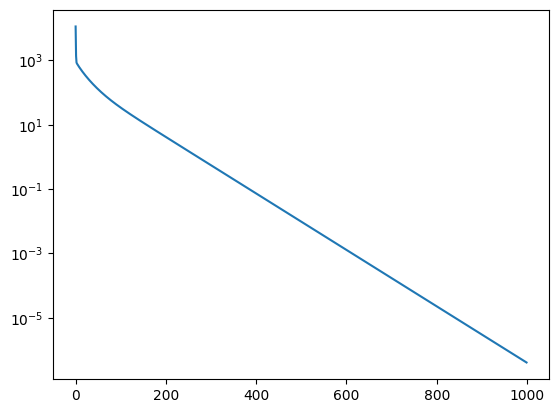

In [5]:
H = np.dot(np.transpose(X),X) + 1/n * np.eye(d)
eigenvals,_ = np.linalg.eig(H)
L = np.max(eigenvals)

def comp_grad(X, w, y, n):
  grad = np.dot(np.transpose(X), (np.dot(X, w) - y)) + 1/n * w
  return grad

def comp_f(X, y, w, n):
  res = 0.5 * (((np.linalg.norm(np.dot(X, w) - y))**2) + 1/n * (np.linalg.norm(w)**2))
  return res

def constant_eta():
  grad_norms = []
  w = np.zeros(d)
  eta = 1/L
  for i in range(max_iterations):
    gradient = comp_grad(X, w, y, n)
    w = w - eta * gradient
    grad_norms.append(np.linalg.norm(gradient))
  return grad_norms

constant_grad_norm = constant_eta()
plt.yscale('log')
plt.plot(constant_grad_norm)

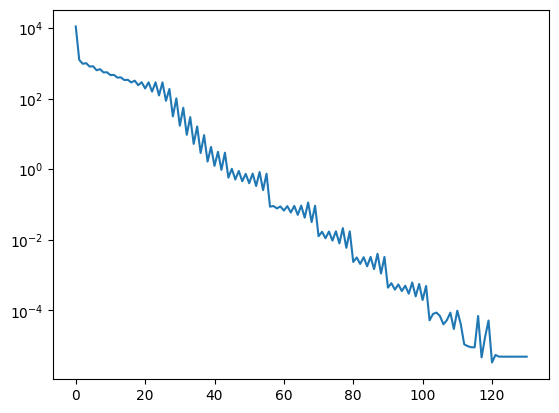

In [6]:
eta_max = 10
c = 0.5
b = 0.9

max_backtracking_iters = 500

def armijo_line_search():
  grad_norms = []
  w = np.zeros(d)
  for i in range(max_iterations):
    eta_k = eta_max
    grad = comp_grad(X, w, y, n)
    if np.linalg.norm(grad) <= min_norm:
      break

    func_val = comp_f(X, y, w, n)

    for j in range(max_backtracking_iters):
      if comp_f(X, y, w - eta_k * grad, n) <=  func_val - c * eta_k * np.linalg.norm(grad)**2:
        break
      else:
        eta_k = eta_k * b
    eta = eta_k
    w = w - eta * grad
    grad_norms.append(np.linalg.norm(grad))
    if len(grad_norms) > 1 and grad_norms[-1] == grad_norms[-2]:
      break
  return grad_norms

armijo_ls_grad_norm = armijo_line_search()
plt.yscale('log')
plt.plot(armijo_ls_grad_norm)

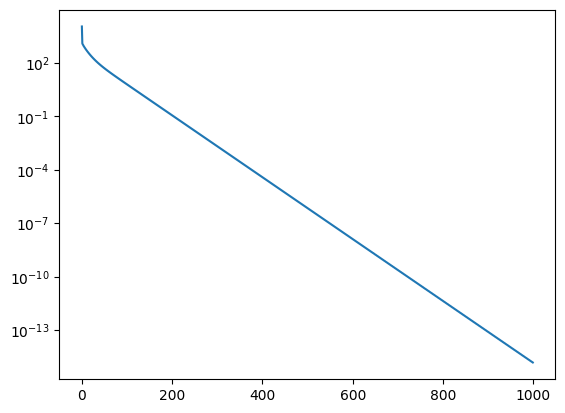

In [7]:
A = np.dot(np.transpose(X), X)+ np.eye(d) * (1 / n)
b = np.dot(np.transpose(X), y)

def CG():
  w = np.zeros(d)
  r = b - A @ w
  p = r
  grad_norms = []
  for k in range(max_iterations):
    grad_norms.append(np.linalg.norm(r))
    if np.linalg.norm(r) < min_norm:
        break
    Ap = A @ p
    alpha = np.linalg.norm(r) ** 2 / (p.T @ Ap)
    w += alpha * p
    r -= alpha * Ap
    beta = (r.T @ r) / (p.T @ Ap)
    p = r + beta * p
  return grad_norms

cg_grad_norms = CG()
plt.yscale('log')
plt.plot(cg_grad_norms)

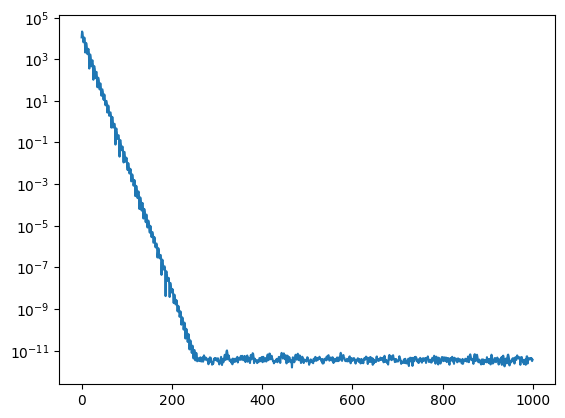

In [8]:
XtX = np.dot(np.transpose(X), X)
Xty = np.dot(np.transpose(X), y)

def comp_grad(w):
  grad = XtX @ w - Xty + (1/n)*w
  return grad

H = np.dot(np.transpose(X),X) + 1/n * np.eye(d)
eigenvals,_ = np.linalg.eig(H)
m = np.min(eigenvals)

def HB():
  eta = 4 / np.square(np.sqrt(L) + np.sqrt(m))
  beta = (np.sqrt(L / m) - 1) / (np.sqrt(L / m) + 1)
  w = np.zeros(d)
  wk = w
  wk_prev = 0
  grad_norms = []

  for k in range(max_iterations):
      grad_norms.append(np.linalg.norm(comp_grad(wk)))
      if np.linalg.norm(np.linalg.norm(comp_grad(wk))) < min_norm:
          break
      wkk = wk - eta * comp_grad(wk) + beta * (wk - wk_prev)
      wk_prev = wk
      wk = wkk
  return grad_norms

hb_grad_norms = HB()
plt.yscale('log')
plt.plot(hb_grad_norms)

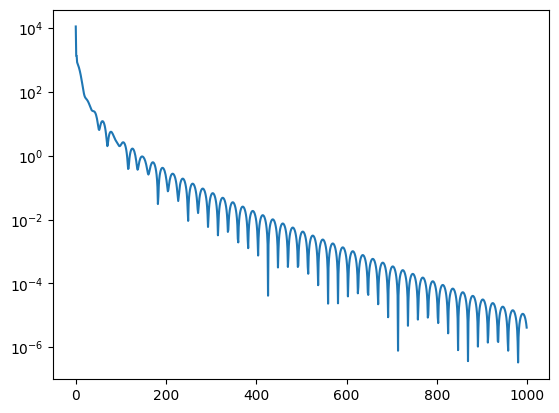

In [9]:
def NA():
  wk = np.zeros(d)
  wk_prev = np.zeros_like(wk)
  eta = 1 / L
  grad_norms = []
  lambda_list = []
  for k in range(max_iterations):
    l = (1 + np.sqrt(1 + 4 * lambda_list[-1] ** 2)) / 2 if k > 0 else 0
    lambda_list.append(l)

  beta_list = [0] * max_iterations
  for k in range(max_iterations-1):
      beta_list[k+1] = (lambda_list[k] - 1) / lambda_list[k+1]

  for k in range(max_iterations):
    grad_norms.append(np.linalg.norm(comp_grad(wk)))
    if np.linalg.norm(comp_grad(wk)) < min_norm:
        break
    vk = wk + beta_list[k] * (wk - wk_prev)
    wkk = vk - eta * comp_grad(vk)
    wk_prev = wk
    wk = wkk

  return grad_norms

na_grad_norms = NA()
plt.yscale('log')
plt.plot(na_grad_norms)

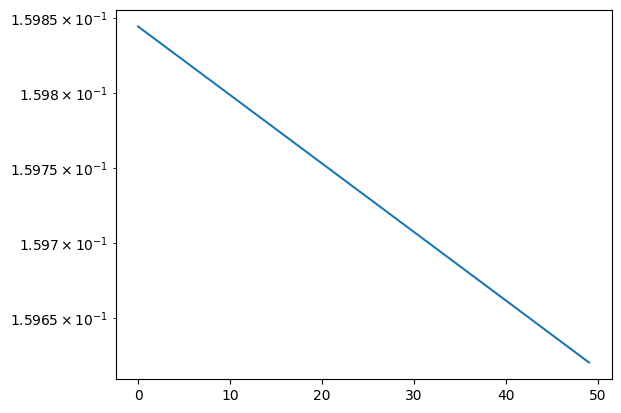

In [11]:
y_X = - np.diag(y) @ X
def logistic_exp(w):
  return np.exp(-y * np.dot(X, w))

def logistic(w):
  g = np.log1p(np.exp(y_X @ w)).mean(axis=0)
  return g + (1/ (2 * n)) * np.linalg.norm(w)

def logistic_grad(w):
  e = np.exp(y_X @ w)
  g = e / (1 + e)
  g = np.expand_dims(g, 1) * y_X
  g = np.sum(g, axis=0)
  reg = (1 / n) * w
  return g / n + reg

def logistic_hessian(w):
  e = np.exp(-y * np.dot(X, w))
  D = np.diag((e / (1 + e)) ** 2)
  H = X.T @ D @ X
  return H

def newton(min_norm=1e-5, max_iterations=50):
  w = np.zeros(22)
  grad_norms = []
  for k in range(max_iterations):
    g = logistic_grad(w)
    g_norm = np.linalg.norm(g)
    grad_norms.append(g_norm)
    if g_norm < min_norm:
        break
    H = logistic_hessian(w)
    d = np.linalg.solve(H, g)
    w -= d
  return grad_norms

newton_grad_norms = newton()
plt.yscale('log')
plt.plot(newton_grad_norms)

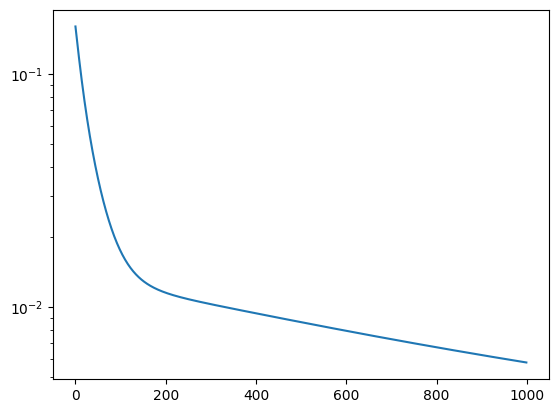

In [16]:
def logistic(w):
    g = np.log1p(np.exp(y_X @ w)).mean(axis=0)
    return g + (1/ (2 * n)) * np.linalg.norm(w)

def backtracking_als():
  w = np.zeros(d)
  grad_norms = []
  for k in range(max_iterations):
    gradient = logistic_grad(w)
    grad_norm = np.linalg.norm(gradient)
    grad_norms.append(grad_norm)
    if grad_norm < min_norm:
      break
    eta = 1
    l = logistic(w)
    c_g = 0.5 * grad_norm ** 2
    while logistic(w - eta * gradient) > l - eta * c_g:
      eta = eta * 0.9
    w = w - eta * gradient

  return grad_norms

backtracking_als_grad_norms = backtracking_als()
plt.yscale('log')
plt.plot(backtracking_als_grad_norms)

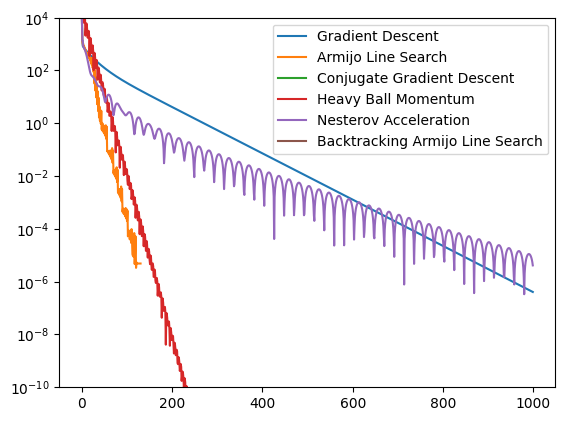

In [17]:
plt.yscale('log')
plt.plot(constant_grad_norm, label = "Gradient Descent")
plt.plot(armijo_ls_grad_norm, label = "Armijo Line Search")
plt.plot(cg_grad_norms[0], label = "Conjugate Gradient Descent")
plt.plot(hb_grad_norms, label = "Heavy Ball Momentum")
plt.plot(na_grad_norms, label = "Nesterov Acceleration")
#plt.plot(newton_grad_norms[0], label = "Newton Gradient")
plt.plot(backtracking_als_grad_norms[0], label = "Backtracking Armijo Line Search")
plt.ylim(pow(10,-10), 10000)
plt.legend()